# Data

### Libraries

In [90]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Data preparation

In [2]:
def load_filtered_data(city):
    '''
    Load filtered data from a city
    '''
    file = ['business', 'checkin', 'review', 'tip', 'user']
    data = {}
    for f in file:
        data[f] = pd.read_csv(f'../filtered_cities/{city}_{f}.csv')
    return data

In [3]:
# load data

city = 'St. Louis'
data = load_filtered_data(city)

In [4]:
# load review sentiment data

sentiment_df = pd.read_csv('../nlp/data/review_sentiment.csv')

sentiment_df

,review_id,text,sentiment
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",-1
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,-1
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1
...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1


#### Users

In [5]:
# user data

data['user'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38816 entries, 0 to 38815
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             38816 non-null  object 
 1   name                38815 non-null  object 
 2   review_count        38816 non-null  int64  
 3   yelping_since       38816 non-null  object 
 4   useful              38816 non-null  int64  
 5   funny               38816 non-null  int64  
 6   cool                38816 non-null  int64  
 7   elite               4042 non-null   object 
 8   friends             24671 non-null  object 
 9   fans                38816 non-null  int64  
 10  average_stars       38816 non-null  float64
 11  compliment_hot      38816 non-null  int64  
 12  compliment_more     38816 non-null  int64  
 13  compliment_profile  38816 non-null  int64  
 14  compliment_cute     38816 non-null  int64  
 15  compliment_list     38816 non-null  int64  
 16  comp

In [6]:
# time series for users

user_ts = data['user'][['user_id', 'yelping_since']].copy()
user_ts = user_ts.rename(columns={'yelping_since': 'date'})
user_ts['date'] = pd.to_datetime(user_ts['date'])
user_ts.set_index('date', inplace=True)

user_ts

,user_id
date,
2009-10-07 17:23:44,_crIokUeTCHVK_JVOy-0qQ
2009-07-11 16:47:38,VcLRGCG_VbAo8MxOm76jzA
2008-01-19 22:50:00,MGPQVLsODMm9ZtYQW-g_OA
2007-02-20 18:21:07,AkBtT43dYcttxQ3qOzPBAg
2007-06-15 20:02:41,3oDIaMM1bd7cwN0eKQv-rA
...,...
2019-12-31 04:45:03,wfMvoUM9RUfvlVse6cicgw
2013-09-28 13:07:24,TvxBAEh4RVOAdS45L0-hDQ
2014-09-01 13:37:12,3LKAT9AGKL4034XCSjckZA


In [7]:
# users per day, week, month, year

users_per_day = user_ts.resample('D').size()
users_per_week = user_ts.resample('W').size()
users_per_month = user_ts.resample('ME').size()
users_per_year = user_ts.resample('YE').size()

#### Checkins

In [8]:
# checkin data

data['checkin'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  1088 non-null   object
 1   date         1088 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [9]:
# time series for checkins

checkin_ts = data['checkin'].copy()
checkin_ts['date'] = checkin_ts['date'].str.split(', ')
checkin_ts = checkin_ts.explode('date')
checkin_ts['date'] = pd.to_datetime(checkin_ts['date'])
checkin_ts.set_index('date', inplace=True)

checkin_ts

,business_id
date,
2014-10-17 18:14:34,-1m7-ZxGRVRdKa4tFB4eDg
2014-10-29 17:01:04,-1m7-ZxGRVRdKa4tFB4eDg
2014-10-29 17:51:48,-1m7-ZxGRVRdKa4tFB4eDg
2015-03-17 12:35:17,-1m7-ZxGRVRdKa4tFB4eDg
2015-04-14 17:46:26,-1m7-ZxGRVRdKa4tFB4eDg
...,...
2020-01-30 19:40:21,zziDpuuJw-Km1J4BaGpBKA
2020-12-21 22:29:50,zziDpuuJw-Km1J4BaGpBKA
2021-07-10 18:14:38,zziDpuuJw-Km1J4BaGpBKA


In [10]:
# checkins per day, week, month, year

checkins_per_day = checkin_ts.resample('D').size()
checkins_per_week = checkin_ts.resample('W').size()
checkins_per_month = checkin_ts.resample('ME').size()
checkins_per_year = checkin_ts.resample('YE').size()

#### Reviews

In [11]:
# review data

data['review'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63451 entries, 0 to 63450
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    63451 non-null  object
 1   user_id      63451 non-null  object
 2   business_id  63451 non-null  object
 3   stars        63451 non-null  int64 
 4   useful       63451 non-null  int64 
 5   funny        63451 non-null  int64 
 6   cool         63451 non-null  int64 
 7   text         63451 non-null  object
 8   date         63451 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.4+ MB


In [12]:
# time series for reviews

review_ts = data['review'][['review_id', 'date']].copy()
review_ts['date'] = pd.to_datetime(review_ts['date'])
review_ts.set_index('date', inplace=True)

review_ts

,review_id
date,
2011-01-08 23:52:22,NvusujU9_5pIUbn9SZ6hMA
2018-06-09 01:37:02,vHOeBa7aMA_na4rfS2Db5A
2010-03-13 22:33:10,hG9RTxxivb0ZXzEk4JXTXA
2017-12-16 03:11:50,zIVkwgahZjOneChZFUYY4g
2015-04-28 20:29:40,DLczAuvMAlAnY5EeDGhTVg
...,...
2014-08-16 02:47:47,OgoBp7fbXnLSKvsQb4O_tw
2021-12-20 11:58:50,Q7e8EtZMmdknDrQE7huMoQ
2019-10-04 21:57:19,zzMW6zbsFaQMjoGu2bGVdA


In [13]:
# reviews per day, week, month, year

reviews_per_day = review_ts.resample('D').size()
reviews_per_week = review_ts.resample('W').size()
reviews_per_month = review_ts.resample('ME').size()
reviews_per_year = review_ts.resample('YE').size()

#### Sentiments

In [14]:
# time series for negative, neutral, and positive reviews

negative_reviews = sentiment_df[sentiment_df['sentiment'] == -1]['review_id']
negative_review_ts = review_ts[review_ts['review_id'].isin(negative_reviews)]

neutral_reviews = sentiment_df[sentiment_df['sentiment'] == 0]['review_id']
neutral_review_ts = review_ts[review_ts['review_id'].isin(neutral_reviews)]

positive_reviews = sentiment_df[sentiment_df['sentiment'] == 1]['review_id']
positive_review_ts = review_ts[review_ts['review_id'].isin(positive_reviews)]

In [15]:
# time series with review sentiments aggregated

sentiment_scores = sentiment_df[['review_id', 'sentiment']].copy()
review_scores_df = review_ts.merge(sentiment_scores, on='review_id')

sentiment_ts = review_ts.merge(review_scores_df, on='review_id')
sentiment_ts.set_index(review_ts.index, inplace=True)

sentiment_ts

,review_id,sentiment
date,,
2011-01-08 23:52:22,NvusujU9_5pIUbn9SZ6hMA,1
2018-06-09 01:37:02,vHOeBa7aMA_na4rfS2Db5A,-1
2010-03-13 22:33:10,hG9RTxxivb0ZXzEk4JXTXA,-1
2017-12-16 03:11:50,zIVkwgahZjOneChZFUYY4g,1
2015-04-28 20:29:40,DLczAuvMAlAnY5EeDGhTVg,1
...,...,...
2014-08-16 02:47:47,OgoBp7fbXnLSKvsQb4O_tw,1
2021-12-20 11:58:50,Q7e8EtZMmdknDrQE7huMoQ,1
2019-10-04 21:57:19,zzMW6zbsFaQMjoGu2bGVdA,1


In [16]:
# review sentiment time series per month

negative_reviews_per_month = negative_review_ts.resample('ME').size()
neutral_reviews_per_month = neutral_review_ts.resample('ME').size()
positive_reviews_per_month = positive_review_ts.resample('ME').size()

In [17]:
# review sentiment per week and month

sentiment_per_week = sentiment_ts.resample('W').agg({'sentiment': 'mean'})
sentiment_per_month = sentiment_ts.resample('ME').agg({'sentiment': 'mean'})

In [18]:
# TODO: check if it is required to deal with missing values (e.g., months with no reviews have NaN sentiment score)

In [19]:
# save sentiment time series

negative_review_ts.to_csv(f'data/negative_review_ts.csv')
neutral_review_ts.to_csv(f'data/neutral_review_ts.csv')
positive_review_ts.to_csv(f'data/positive_review_ts.csv')
sentiment_ts.to_csv(f'data/sentiment_ts.csv')

### Visualization

In [20]:
def time_series_plot(df_per_day, df_per_week, df_per_month, df_per_year, content='Reviews'):
    '''
    Plot time series data with subplots
    '''
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    color = 'blue'
    if content == 'Users':
        color = 'pink'
    elif content == 'Checkins':
        color = 'orange'
    
    axs[0, 0].plot(df_per_day, color=color)
    axs[0, 0].set_title(f'{content} per Day')
    axs[0, 0].set_ylabel(f'Number of {content}')

    axs[0, 1].plot(df_per_week, color=color)
    axs[0, 1].set_title(f'{content} per Week')
    axs[0, 1].set_ylabel(f'Number of {content}')
    
    axs[1, 0].plot(df_per_month, color=color)
    axs[1, 0].set_title(f'{content} per Month')
    axs[1, 0].set_ylabel(f'Number of {content}')
    
    axs[1, 1].plot(df_per_year, color=color)
    axs[1, 1].set_title(f'{content} per Year')
    axs[1, 1].set_ylabel(f'Number of {content}')
    
    plt.tight_layout()
    plt.show()

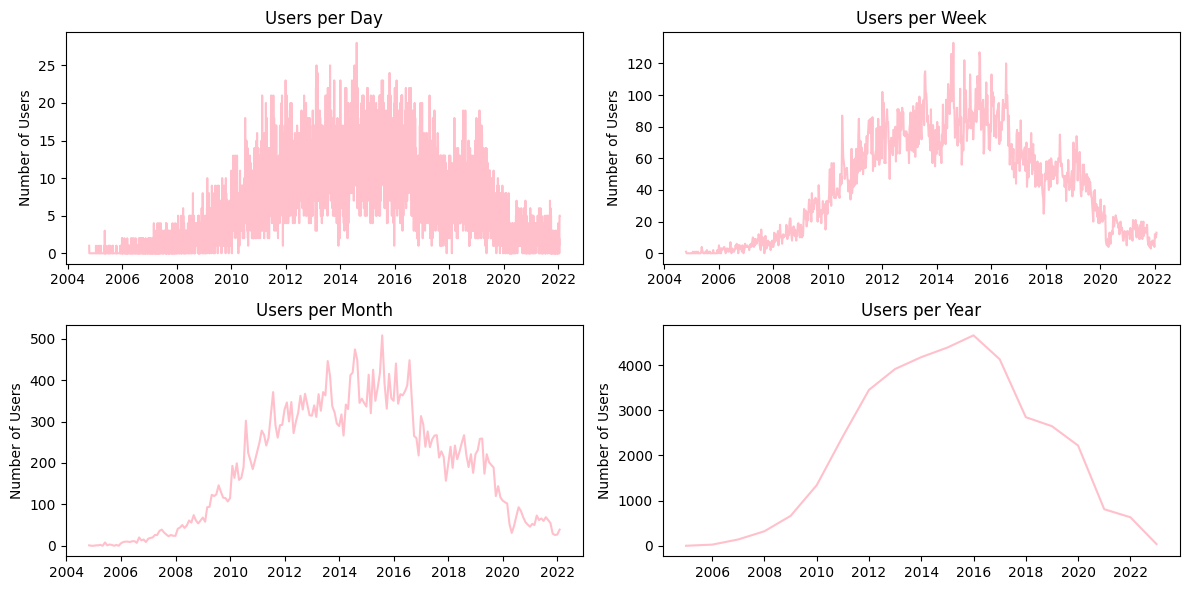

In [21]:
# time series plot for users

time_series_plot(users_per_day, users_per_week, users_per_month, users_per_year, content='Users')

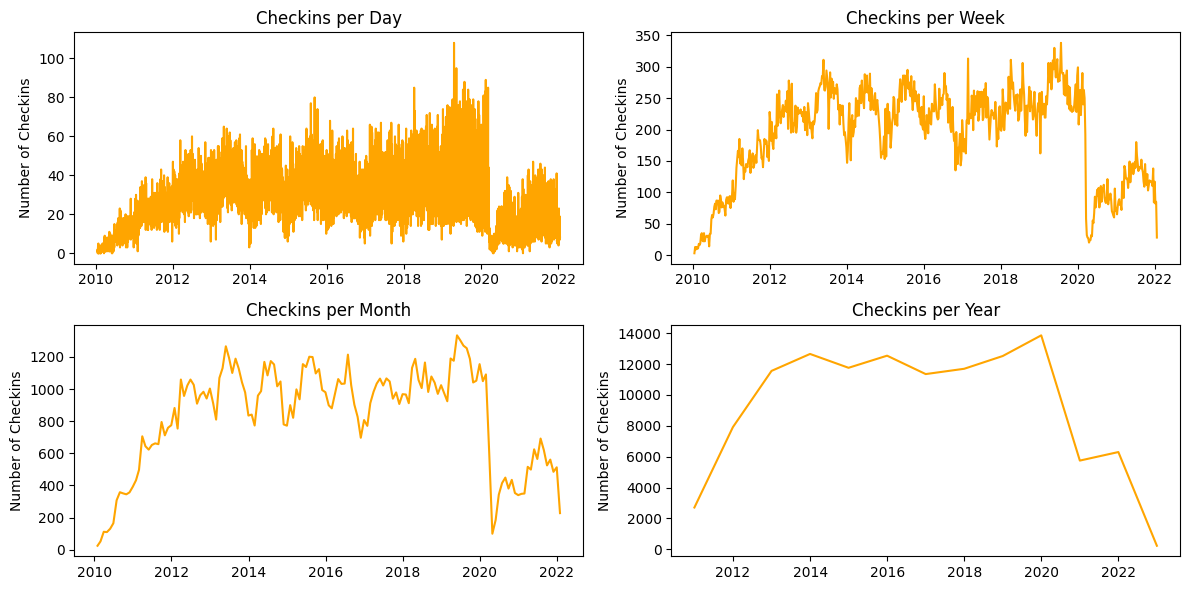

In [22]:
# time series plot for checkins

time_series_plot(checkins_per_day, checkins_per_week, checkins_per_month, checkins_per_year, content='Checkins')

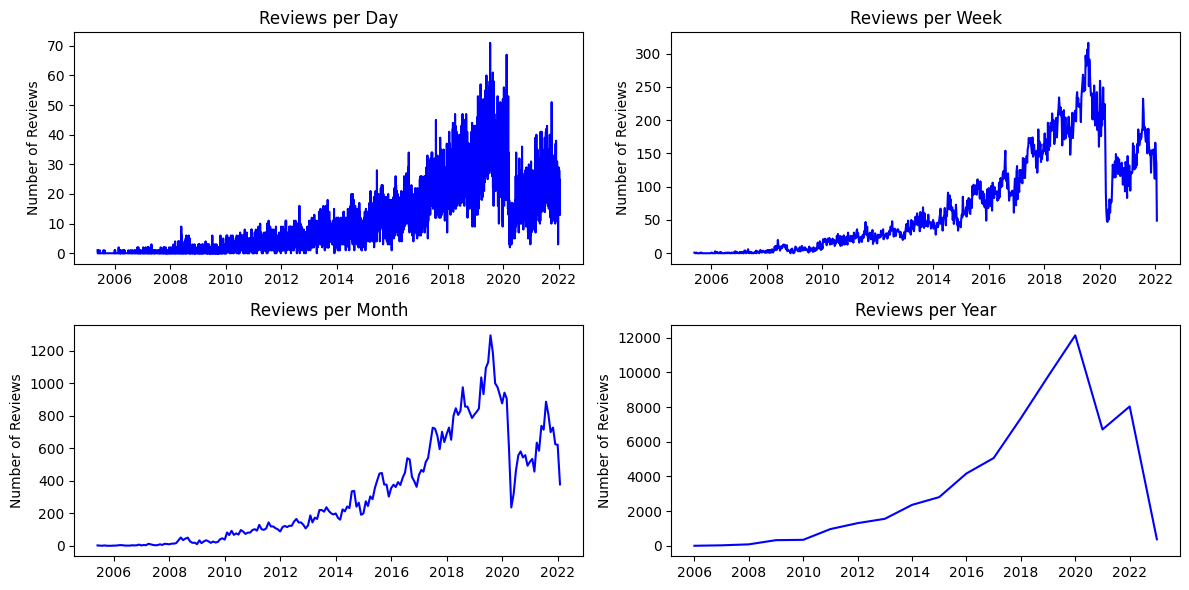

In [23]:
# time series plot for reviews

time_series_plot(reviews_per_day, reviews_per_week, reviews_per_month, reviews_per_year, content='Reviews')

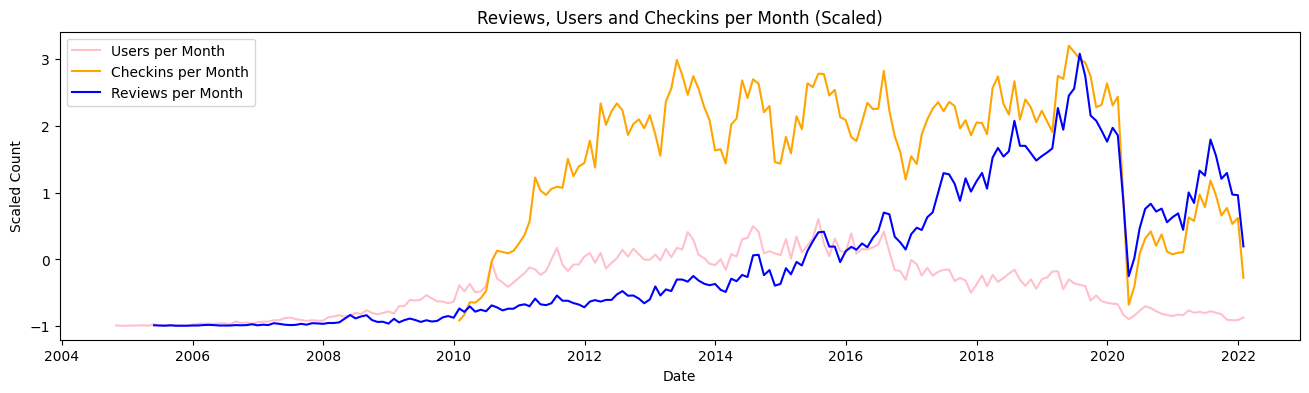

In [24]:
# comparison between reviews, users and checkins over time (with standardization)

scaler = StandardScaler()

reviews_per_month_scaled = scaler.fit_transform(reviews_per_month.values.reshape(-1, 1))
users_per_month_scaled = scaler.transform(users_per_month.values.reshape(-1, 1))
checkins_per_month_scaled = scaler.transform(checkins_per_month.values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(users_per_month.index, users_per_month_scaled, color='pink', label='Users per Month')
ax.plot(checkins_per_month.index, checkins_per_month_scaled, color='orange', label='Checkins per Month')
ax.plot(reviews_per_month.index, reviews_per_month_scaled, color='blue', label='Reviews per Month')
ax.set_title('Reviews, Users and Checkins per Month (Scaled)')
ax.set_xlabel('Date')
ax.set_ylabel('Scaled Count')
ax.legend()
plt.show()

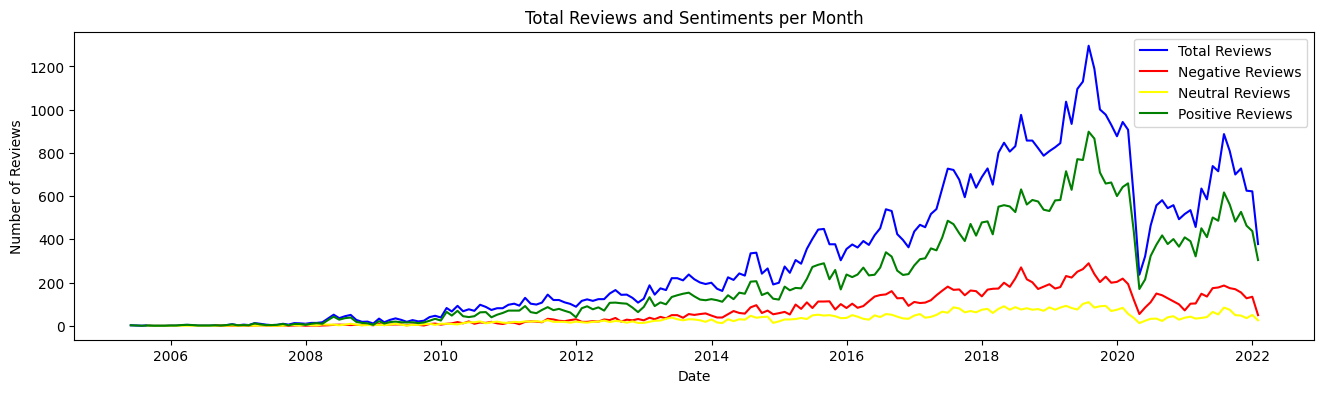

In [25]:
# comparison of total reviews and sentiments per month

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(reviews_per_month.index, reviews_per_month, color='blue', label='Total Reviews')
ax.plot(negative_reviews_per_month.index, negative_reviews_per_month, color='red', label='Negative Reviews')
ax.plot(neutral_reviews_per_month.index, neutral_reviews_per_month, color='yellow', label='Neutral Reviews')
ax.plot(positive_reviews_per_month.index, positive_reviews_per_month, color='green', label='Positive Reviews')

ax.set_title('Total Reviews and Sentiments per Month')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Reviews')
ax.legend()
plt.show()

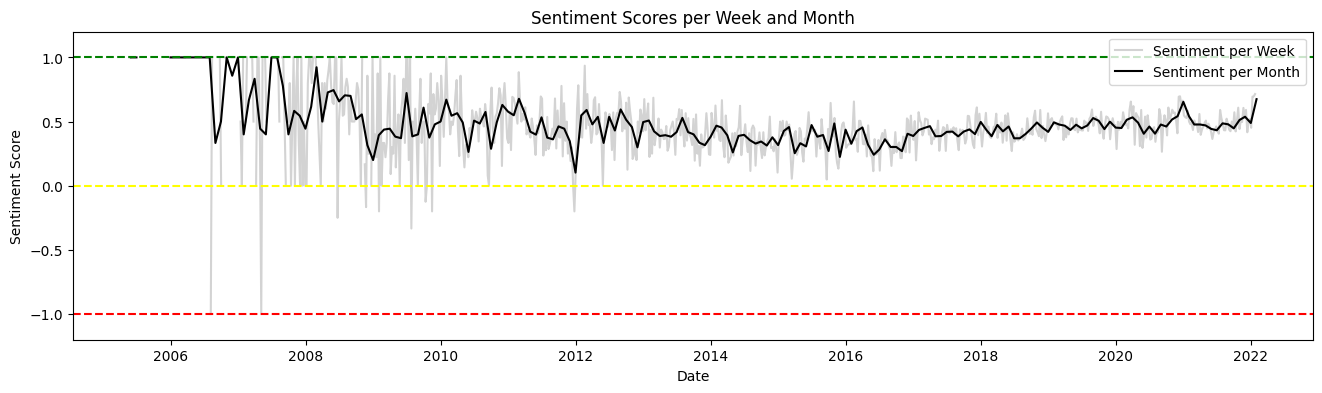

In [26]:
# time series of sentiment scores per week and month

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(sentiment_per_week, color='lightgray', label='Sentiment per Week')
ax.plot(sentiment_per_month, color='black', label='Sentiment per Month')

plt.ylim(-1.2, 1.2)
plt.axhline(y=1, color='green', linestyle='--')
plt.axhline(y=0, color='yellow', linestyle='--')
plt.axhline(y=-1, color='red', linestyle='--')

plt.title('Sentiment Scores per Week and Month')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

### Autocorrelation and partial autocorrelation

In [76]:
def lag_plots(time_series, lags=5, title='Lag Plots'):
    '''
    Plot lag plots for time series data
    '''
    fig, axes = plt.subplots(nrows=1, ncols=lags, figsize=(15, 3))

    for lag in range(1, lags + 1):
        ax = axes[lag - 1]
        lag_plot(time_series, lag=lag, ax=ax)
        ax.set_title(f'Lag {lag}')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

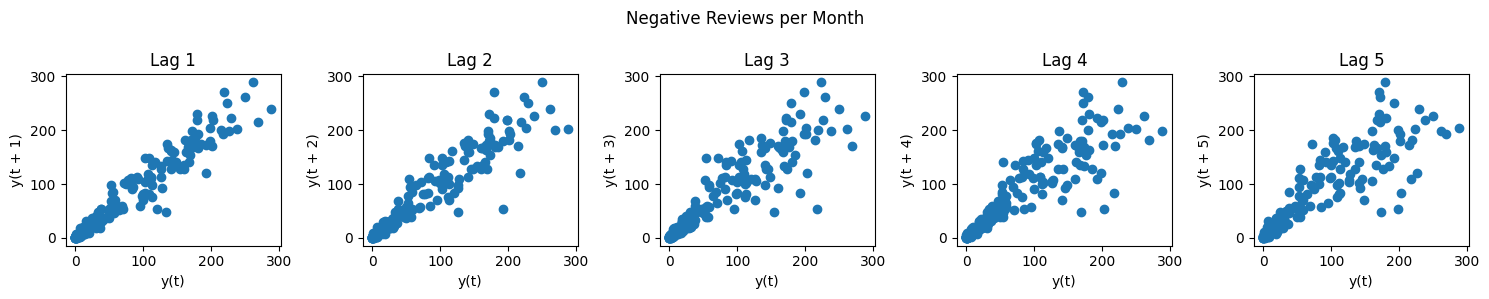

In [78]:
# lag plots for negative reviews per month

lag_plots(negative_reviews_per_month, lags=5, title='Negative Reviews per Month')

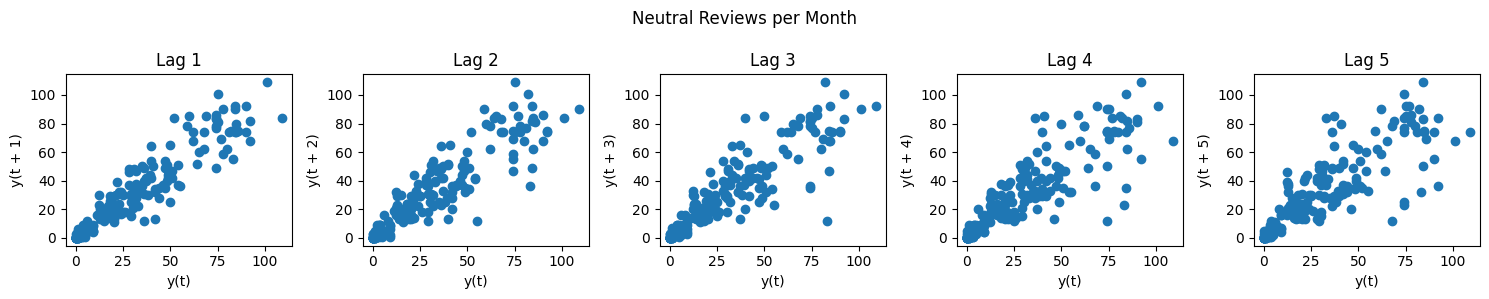

In [79]:
# lag plots for neutral reviews per month

lag_plots(neutral_reviews_per_month, lags=5, title='Neutral Reviews per Month')

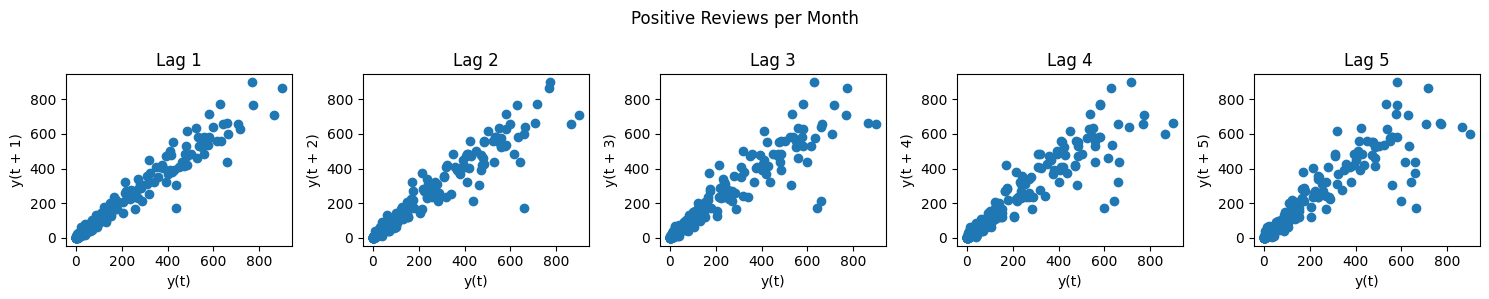

In [80]:
# lag plots for positive reviews per month

lag_plots(positive_reviews_per_month, lags=5, title='Positive Reviews per Month')

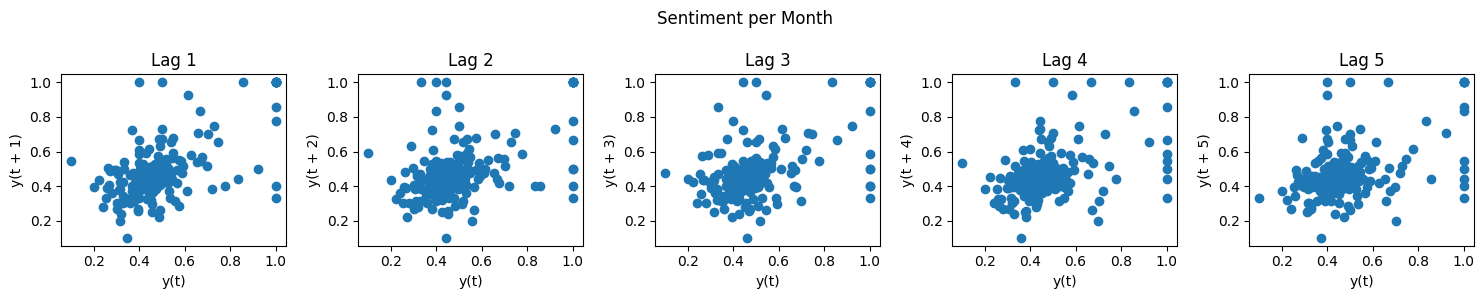

In [81]:
# lag plots for sentiment scores per month

lag_plots(sentiment_per_month, lags=5, title='Sentiment per Month')

In [84]:
def acf_and_pacf_plots(time_series, title='ACF and PACF Plots'):
    '''
    Plot ACF and PACF plots for time series data
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    plot_acf(time_series, ax=axes[0])
    plot_pacf(time_series, ax=axes[1])

    axes[0].set_title('ACF')
    axes[1].set_title('PACF')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

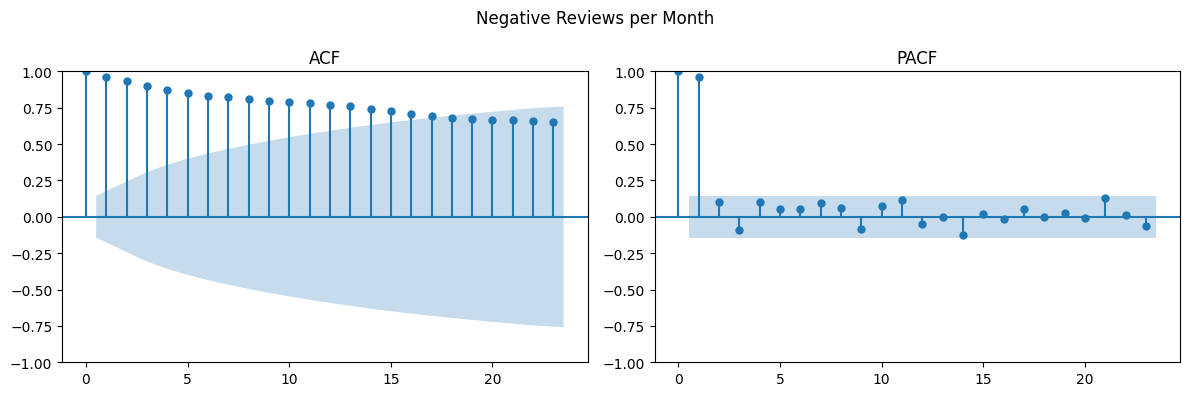

In [85]:
# ACF and PACF plots for negative reviews per month

acf_and_pacf_plots(negative_reviews_per_month, title='Negative Reviews per Month')

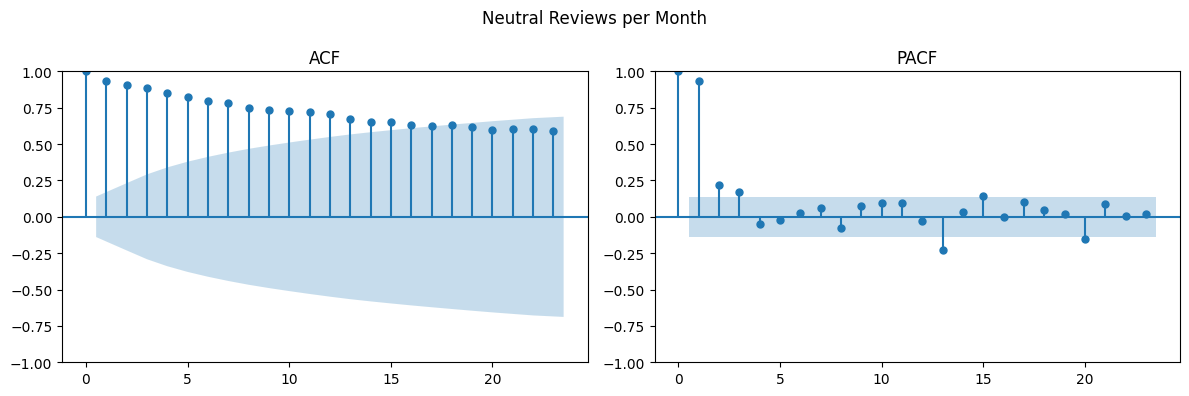

In [86]:
# autocorrelation plots for neutral reviews per month

acf_and_pacf_plots(neutral_reviews_per_month, title='Neutral Reviews per Month')

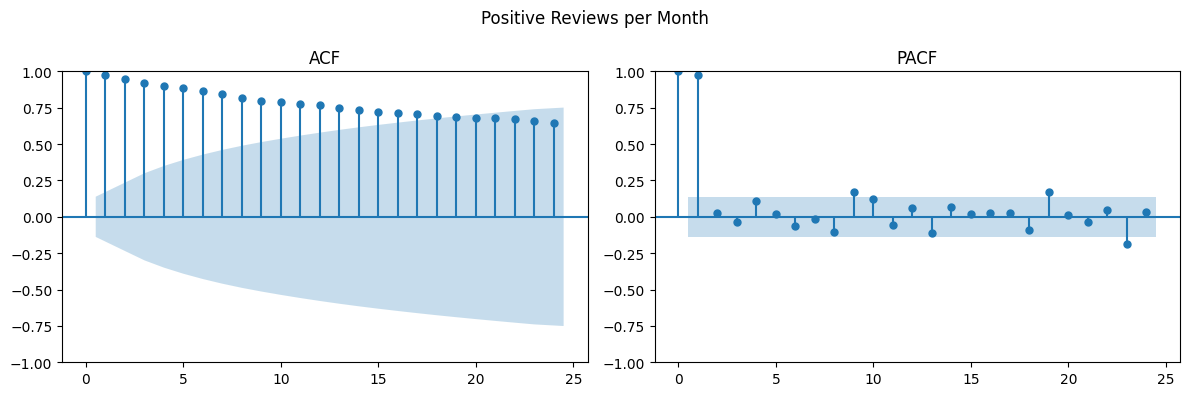

In [87]:
# autocorrelation function for positive reviews per month

acf_and_pacf_plots(positive_reviews_per_month, title='Positive Reviews per Month')

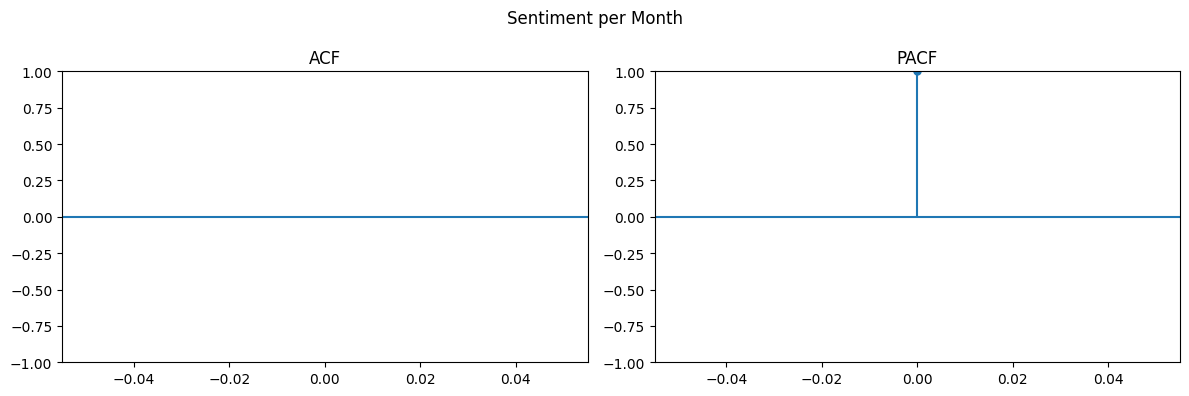

In [88]:
# autocorrelation function for sentiment scores per month

acf_and_pacf_plots(sentiment_per_month, title='Sentiment per Month')

# TODO: check why ACF and PACF are like this with this time series

### Stationarity

In [ ]:
# TODO: apply stationarity tests - ADF, KPSS, PP